In [4]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, load_metric
import torch

# Load the datasets
ariq = pd.read_csv('comments - ariq.csv')
fadel = pd.read_csv('comments - fadel.csv')
kemas = pd.read_csv('comments - kemas.csv')

# Combine all dataframes
df = pd.concat([ariq, fadel, kemas])

# Rename columns
df.rename(columns={'(1: positif, 0: negatif, 2: netral)': 'Sentiment'}, inplace=True)

# Drop rows where Sentiment is NaN
df.dropna(subset=['Sentiment'], inplace=True)

# Clean text function
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # remove mentions
    text = re.sub(r'#', '', text)  # remove hashtag symbol
    text = re.sub(r'RT[\s]+', '', text)  # remove RT
    text = re.sub(r'https?:\/\/\S+', '', text)  # remove hyperlink
    text = re.sub(r'\n', '', text)  # remove newline
    return text

# Apply clean_text function
df['text'] = df['text'].apply(clean_text)

# Remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Apply remove_emoji function
df['text'] = df['text'].apply(remove_emoji)

# Ensure Sentiment column is of integer type
df['Sentiment'] = df['Sentiment'].astype(int)

# Split the dataset
train_df, eval_df = train_test_split(df[["text", "Sentiment"]], test_size=0.2, random_state=23)

# Convert text column to string
train_df['text'] = train_df['text'].astype(str)
eval_df['text'] = eval_df['text'].astype(str)

# Create Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

# Define the tokenize function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

# Apply the tokenize function to the dataset
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

# Ensure the tokenized datasets have the correct format
tokenized_train_dataset = tokenized_train_dataset.rename_column("Sentiment", "labels")
tokenized_eval_dataset = tokenized_eval_dataset.rename_column("Sentiment", "labels")

# Set the format of the datasets to tensors
tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_eval_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# # Load the pre-trained model
# model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)

# # Define training arguments
# training_args = TrainingArguments(
#     output_dir="./results",
#     evaluation_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=100,
#     weight_decay=0.01,
# )

# # Define the Trainer
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_train_dataset,
#     eval_dataset=tokenized_eval_dataset,
#     compute_metrics=lambda p: {"accuracy": (p.predictions.argmax(-1) == p.label_ids).mean()}
# )

# # Train the model
# trainer.train()


In [8]:
state_dict = torch.load("pytorch_model.bin")

In [9]:
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [13]:
# Perform inference on eval dataset
eval_predictions = []

# Set up the DataLoader
eval_dataloader = torch.utils.data.DataLoader(tokenized_eval_dataset, batch_size=8)

# Move model to the same device as the data
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Iterate over batches
for batch in eval_dataloader:
    with torch.no_grad():
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Perform forward pass
        outputs = model(input_ids, attention_mask=attention_mask)

    # Extract predicted labels
    predictions = torch.argmax(outputs.logits, dim=1).tolist()
    eval_predictions.extend(predictions)

# Convert predicted labels to numpy array
eval_predictions = np.array(eval_predictions)

# Print or use eval_predictions for further analysis
print(eval_predictions)


[0 0 1 1 1 0 1 0 2 1 1 1 1 2 0 2 2 0 0 1 1 2 1 0 1 0 0 0 2 1 1 1 0 1 0 1 1
 1 0 1 0 2 2 1 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 2 0 2 1 1 2 1
 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1
 1 1 1 0 0 0 1 0 1 1 2 0 1 1 1 2 2 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 2 1 0 0
 1 1 1 2 1 1 0 2 1 1 0 2 0 1 1 1 0 1 2 1 0 1 1 0 1 0 0 0 1 1 2 1 2 0 1 1 1
 0 1 0 0 2 2 0 1 0 0 0 2 1 1 1 1 1 1 1 1 1 2 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1
 2 0 0 0 1 0 2 2 1 1 0 1 1 1 0 0 1 1 1 1 2 1 0 1 1 1 1 0 1 0 1 0 1 1 1 2 1
 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 2 1 0 1 2 1 1 0 1 2 0 0 1
 1 2 2 1 1 1 0 0 2 1 0 1 0 0 2 2 1 1 0 0 0 2 0 1 1 0 1 0 0 0 1 1 1 1 0 1 0
 1 0 2 1 1 2 0 2 0 1 2 0 1 1 1 0 2 1 1 1 1 1 1 0 0]


In [24]:
y_pred = eval_predictions

In [25]:
y_te = np.array(eval_df['Sentiment'])
y_te

array([0, 0, 1, 1, 1, 0, 1, 2, 0, 2, 1, 1, 1, 2, 0, 0, 2, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 2, 1,
       0, 2, 0, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1,
       1, 2, 0, 2, 1, 1, 1, 2, 1, 2, 0, 2, 1, 1, 1, 0, 1, 1, 2, 1, 2, 0,
       2, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 2, 0, 2, 1, 1, 0, 2, 2, 1, 2, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 2, 2, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       2, 1, 1, 2, 0, 0, 2, 2, 2, 1, 2, 1, 0, 1, 0, 1, 2, 1, 1, 0, 0, 0,
       1, 1, 2, 1, 1, 0, 2, 1, 1, 0, 1, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 1,
       1, 1, 2, 1, 2, 1, 0, 2, 0, 1, 0, 1, 0, 2, 2, 1, 1, 0, 1, 0, 1, 2,
       1, 1, 2, 2, 0, 0, 1, 0, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       2, 1, 0, 1, 1, 1, 0, 0, 1, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 2, 2, 1, 2, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 2, 0, 0,
       1, 2, 1, 1, 0, 1, 2, 0, 0, 2, 1, 0, 1, 1, 1,

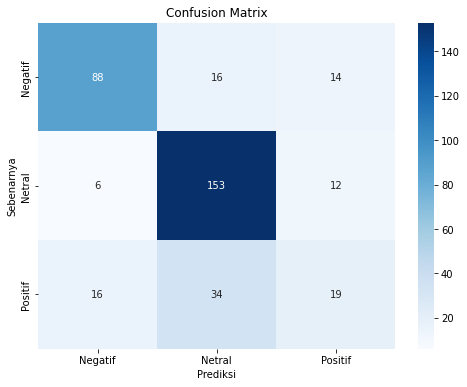

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(eval_df["Sentiment"], eval_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Netral', 'Positif'], yticklabels=['Negatif', 'Netral', 'Positif'])
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
plt.title('Confusion Matrix')
plt.show()


In [27]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(eval_df["Sentiment"], eval_predictions, target_names=['Negatif', 'Netral', 'Positif'])

# Print classification report
print(report)


              precision    recall  f1-score   support

     Negatif       0.80      0.75      0.77       118
      Netral       0.75      0.89      0.82       171
     Positif       0.42      0.28      0.33        69

    accuracy                           0.73       358
   macro avg       0.66      0.64      0.64       358
weighted avg       0.71      0.73      0.71       358



In [29]:
from sklearn.metrics import accuracy_score
np.round(accuracy_score(y_te, y_pred),3)

0.726

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve

In [33]:
# Perform inference on eval dataset
eval_probabilities = []

# Set up the DataLoader
eval_dataloader = torch.utils.data.DataLoader(tokenized_eval_dataset, batch_size=8)

# Move model to the same device as the data
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Iterate over batches
for batch in eval_dataloader:
    with torch.no_grad():
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Perform forward pass
        outputs = model(input_ids, attention_mask=attention_mask)

    # Apply softmax to logits to get probabilities
    probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()
    eval_probabilities.extend(probs)

# Convert probabilities to numpy array
eval_probabilities = np.array(eval_probabilities)

c = eval_probabilities
# Print or use eval_probabilities for further analysis
print(eval_probabilities)


[[9.9997842e-01 9.0245230e-06 1.2481080e-05]
 [9.9995720e-01 3.1191583e-05 1.1558047e-05]
 [9.3235285e-06 9.9997926e-01 1.1465325e-05]
 ...
 [9.6218773e-06 9.9997962e-01 1.0732670e-05]
 [9.9997926e-01 9.0565509e-06 1.1701721e-05]
 [9.9994504e-01 4.7779347e-05 7.1967952e-06]]


In [35]:
roc_auc_score(y_te, c, multi_class='ovr')

0.8424730200419935

In [39]:
# calculate hamming loss
from sklearn.metrics import hamming_loss
np.round(hamming_loss(y_te, y_pred),3)

0.274